# Extreme Heat exposure assessment

In this notebook, we will perform an **extreme heat exposure assessment** for transportation infrastructure, specifically focusing on railways. The assessment is based on combining hazard data (e.g., occurence of extreme temperatures) with spatial information on railway infrastructure to understand how future climate could increase the impact of extreme heat on the performance of railway infrastructure.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., railways) and hazard data (e.g., PGA levels) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the exposure assessment:**  
   We will overlay the railway infrastructure data with data on extreme heat.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated damage using graphs and maps to illustrate the impact on railway infrastructure.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [1]:
#!pip install damagescanner==0.9b13
#!pip install contextily
#!pip install exactextract
#!pip install lonboard

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [30]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely
from tqdm import tqdm

import matplotlib.pyplot as plt
import contextily as cx

import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
from damagescanner.base_values import DICT_CIS_VULNERABILITY_FLOOD
from statistics import mode

from lonboard import viz

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [3]:
country_full_name = 'Serbia'
country_iso3 = 'SRB'

## 2. Loading the Data
In this step, we will load four key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of transportation infrastructure (e.g., roads). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

3. **Vulnerability curves:**  
   Vulnerability curves define how the infrastructure's damage increases with the intensity of the hazard. For example, flood depth-damage curves specify how much damage occurs for different flood depths.

4. **Maximum damage values:**  
   This dataset contains the maximum possible damage (in monetary terms) that can be incurred by individual infrastructure assets. This is crucial for calculating total damage based on the vulnerability curves.

### Infrastructure Data

We will perform this example analysis for Tajikistan. To start the analysis, we first download the OpenStreetMap data from GeoFabrik. In case of locally available data, one can load the shapefiles through **gpd.read_file()**, as we show in the second cell within this section.

In [4]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

Now we load the data and read only the road data.

In [5]:
%%time
features = read_osm_data(infrastructure_path,asset_type='rail')

CPU times: total: 26.7 s
Wall time: 31.6 s


In [6]:
features.total_bounds

array([18.9621984, 42.2235539, 22.8397858, 46.1922594])

In [7]:
sub_types = features.object_type.unique()

In [8]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

In [9]:
admin1 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_1_states_provinces.shp")

### Hazard Data
Dealing with extreme heat is generally quite complicated. As extreme temperatures vary greatly across the world, infrastructure is also built differently for that wide range of possible temperatures. Moreover, when it comes to extreme heat, we are most interested on how climate change may change those temperature extremes. However, high-resolution climate data is very data-intensive, and it can be complicated to decide which climate model one should use for the specific region of interest. The latest set of climate projections, clustered within [CMIP-6], contains a large amount of different climate runs and climate models. All combined, they show a large possible range of futures. 

As such, we strongly suggest to look for regional or nationally-downscaled heat information to perform such an analysis. For the sake of showcasing how one could potentially assess the exposure of extreme heat on infrastructure, we show an example approach using *high resolution climate change observations and projections for the evaluation of heat-related extremes* developed by [**Williams et al., 2024](https://www.nature.com/articles/s41597-024-03074-w). The full dataset can be found [here](https://data.chc.ucsb.edu/products/CHC_CMIP6/). 

**Please note:** we require quite a lot of data-specific steps to get this analysis working. As such, different to the other hazards, this approach might be more difficult to quickly re-do with other extreme heat data.

Here we will show how to extract all data to identify how often temperature exceeded 30 degrees, and how this may change towards the future. We will exemplify this approach for **Serbia** and, as such, only grab the relevant warmest months for **Serbia** (May to September). For different countries, one may want to select different months.

Let's first first select the years and months we want to consider:

In [10]:
years = [str(x) for x in np.arange(1983,2017,1)]
months = ['0'+str(x) for x in np.arange(7,9,1)]

And specify whether we want to look at 30 degrees (`30C`) or 40.6 (`40p6`) degrees plus:

In [11]:
Tmax_type = '30C'

In [12]:
collect_country_data = {}
for month in months:
    for year in tqdm(years,total=len(years),desc=month):
        file_name = f'https://data.chc.ucsb.edu/products/CHC_CMIP6/extremes/Tmax/observations/{month}/Daily_Tmax_{year}_{month}_cnt_Tmaxgt{Tmax_type}.tif'
        hazard_map = xr.open_dataset(file_name, engine="rasterio")

        collect_country_data[(month,year)]= hazard_map.rio.clip_box(minx=features.total_bounds[0],
                             miny=features.total_bounds[1],
                             maxx=features.total_bounds[2],
                             maxy=features.total_bounds[3]
                            )

08: 100%|██████████████████████████████████████████████████████████████████████████████| 34/34 [00:19<00:00,  1.74it/s]


In [13]:
collect_exposure = []
for month in months:
    for year in tqdm(years,total=len(years),desc=month):
        country_hazard_data = collect_country_data[(month,year)]
        exposed_features = DamageScanner(country_hazard_data, features, pd.DataFrame(), pd.DataFrame()).exposure(disable_progress=True)#'values']
        exposed_features['max_exposure'] = exposed_features.apply(
            lambda feature: np.max([x for x in feature['values']]), axis=1
        )
        exposed_features = exposed_features.rename(columns={'max_exposure': (month,year)})
        collect_exposure.append(exposed_features[(month,year)])

08: 100%|██████████████████████████████████████████████████████████████████████████████| 34/34 [13:06<00:00, 23.14s/it]


In [26]:
df_baseline = pd.concat(collect_exposure,axis=1).groupby(level=1,axis=1).sum()

Future

In [15]:
collect_country_data_2050_SSP585 = {}
for month in months:
    for year in tqdm(years,total=len(years),desc=month):
        file_name = f'https://data.chc.ucsb.edu/products/CHC_CMIP6/extremes/Tmax/2050_SSP585/{month}/Daily_Tmax_{year}_{month}_cnt_Tmaxgt{Tmax_type}.tif'
        hazard_map = xr.open_dataset(file_name, engine="rasterio")

        collect_country_data_2050_SSP585[(month,year)]= hazard_map.rio.clip_box(minx=features.total_bounds[0],
                             miny=features.total_bounds[1],
                             maxx=features.total_bounds[2],
                             maxy=features.total_bounds[3]
                            )

08: 100%|██████████████████████████████████████████████████████████████████████████████| 34/34 [00:19<00:00,  1.72it/s]


In [16]:
collect_country_data_2050_SSP585[(month,year)]

<xarray.Dataset> Size: 26kB
Dimensions:      (band: 1, x: 78, y: 80)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 624B 18.98 19.03 19.08 19.13 ... 22.73 22.78 22.83
  * y            (y) float64 640B 46.17 46.12 46.07 46.02 ... 42.32 42.27 42.22
    spatial_ref  int32 4B 0
Data variables:
    band_data    (band, y, x) float32 25kB ...

In [17]:
collect_exposure_2050_SSP585 = []
for month in months:
    for year in tqdm(years,total=len(years),desc=month):
        country_hazard_data = collect_country_data_2050_SSP585[(month,year)]
        exposed_features = DamageScanner(country_hazard_data, features, pd.DataFrame(), pd.DataFrame()).exposure(disable_progress=True)#'values']
        exposed_features['max_exposure'] = exposed_features.apply(
            lambda feature: np.max([x for x in feature['values']]), axis=1
        )
        exposed_features = exposed_features.rename(columns={'max_exposure': (month,year)})
        collect_exposure_2050_SSP585.append(exposed_features[(month,year)])

08: 100%|██████████████████████████████████████████████████████████████████████████████| 34/34 [12:52<00:00, 22.72s/it]


In [28]:
df_future = pd.concat(collect_exposure_2050_SSP585,axis=1).groupby(level=1,axis=1).sum()

And plot some outputs

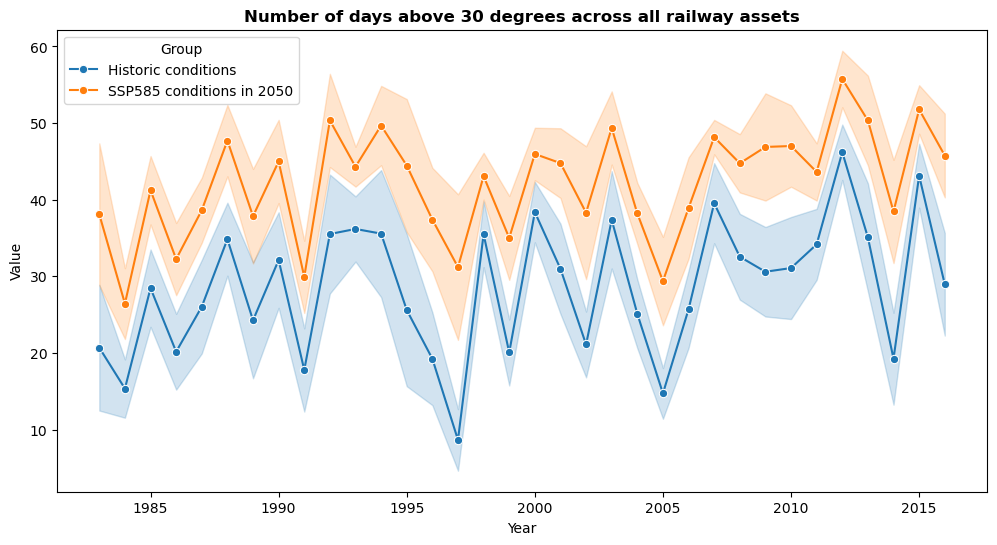

In [34]:
# Convert df_baseline to long format and add a group identifier
df_baseline_long = df_baseline.melt(var_name='Year', value_name='Value')
df_baseline_long['Year'] = df_baseline_long['Year'].astype(int)
df_baseline_long['Group'] = 'Historic conditions'

# Convert df_future to long format and add a group identifier
df_future_long = df_future.melt(var_name='Year', value_name='Value')
df_future_long['Year'] = df_future_long['Year'].astype(int)
df_future_long['Group'] = 'SSP585 conditions in 2050'

# Concatenate the two long dataframes
df_combined = pd.concat([df_baseline_long, df_future_long], axis=0)

# Define a color palette for the two groups
palette = {'Historic conditions': '#1f77b4',  # blue-ish
           'SSP585 conditions in 2050': '#ff7f0e'}    # orange-ish

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Value', hue='Group', data=df_combined, ci='sd', marker='o', palette=palette)
plt.title('Number of days above 30 degrees across all railway assets',fontweight='bold')
plt.show()
